In [1]:
import numpy as np
import emcee
import modal
import lab
import corner
import torch
import models
from numba import jit
import matplotlib.pyplot as plt
import pydvma as dvma
import sampler
import pints
import pints.plot
from tqdm import tqdm
import scienceplots

In [2]:
plt.style.use('science')
plt.rcParams.update({"font.size":13})

In [79]:
mpl.rcParams['text.usetex'] = False

In [3]:
class ModalSumDB(pints.ForwardModel):
    def __init__(self, param, phase_flag):
        super().__init__()
        self.dimension = len(param) - 1
        self.phase_flag = phase_flag

    # @jit(nopython=True)
    def simulate(self, thetas, w):
        tf = np.zeros_like(w, dtype=np.complex64)
        if self.phase_flag:
            n = len(thetas) // 4
            w_n, a_n, z_n, p_n = thetas[:n], thetas[n:2*n], thetas[2*n:3*n], thetas[3*n:4*n]
            for i in range(len(a_n)):
                tf += a_n[i] * 1j * w * np.exp(p_n[i] * 1j) / (w_n[i] ** 2 - w**2 + 2j * z_n[i] * w * w_n[i])
        else:
            n = len(thetas) // 3
            w_n, a_n, z_n = thetas[:n], thetas[n:2*n], thetas[2*n:3*n]
            for i in range(len(a_n)):
                tf += a_n[i] * 1j * w / (w_n[i] ** 2 - w**2 + 2j * z_n[i] * w * w_n[i])

        # tf[0] += 0.01 + 0.01j
        tf[0] = tf[1]
        tf_db = 20 * np.log10(np.sqrt(tf.real ** 2 + tf.imag ** 2))

        return tf_db

    def n_parameters(self):
        return self.dimension

In [4]:
class Sampler:
    def __init__(self, model, raw_tf, w=None, prior="uniform"):
        """
        Initialize the Sampler class.

        Parameters
        ----------
        model : torch.nn.Module
            The trained model to be used for sampling.
        raw_tf : np.ndarray
            The raw transfer function to be used for sampling.
            Shape (n, ) where n is the number of frequency points.
            Each entry is a complex number.
        w : np.ndarray, optional
            The frequency points at which the transfer function is sampled.
            Shape (n, ) where n is the number of frequency points.
        """
        self.model = model
        self.raw_tf = raw_tf
        if w is None:
            self.w = np.linspace(0, 1, len(raw_tf))
        else:
            self.w = w
        # self.tf_db = modal.to_db(self.raw_tf) 
        self.tf_db = 20 * np.log10(np.sqrt(raw_tf.real ** 2 + raw_tf.imag ** 2))
        self.real_tf = np.real(self.raw_tf)
        self.run_flag = False

    def run_sampler(
        self,
        nwalkers: int = 100,
        nsteps: int = 1000,
        plot_predictions: bool = True,
        reparamaterize: bool = False,
        prior: str = "uniform",
        sampler: str = "emcee",
        pints_sampler = pints.EmceeHammerMCMC,
        phase: bool = False,
        sample_cutoff: int = -1,
        return_results: bool = False,
    ) -> None:

        assert prior in [
            "uniform",
            "normal",
        ], "Prior type must be 'uniform' or 'normal'."
        assert sampler in [
            "emcee",
            "pcn",
            "pints",
        ], "Sampler type must be 'emcee' or 'pcn' or 'pints'."

        # assuming multiclass model
        raw_predictions = self.get_lab_predictions(plot_tf=plot_predictions)
        self.predictions = np.argmax(raw_predictions, axis=-1).reshape(-1)

        self.sample_cutoff = sample_cutoff
        self.predictions = self.predictions[:sample_cutoff]
        
        self.reparamaterize = reparamaterize
        self.prior_type = prior
        self.sampler_type = sampler
        self.phase_flag = phase
        
        log_prior = self.get_log_prior() # obtains self.mins and self.maxs
        # log_posterior = self.get_log_posterior(log_prior)
        self.log_prior = log_prior
        log_posterior = self.get_log_posterior()

        self.burned_flag = False
        self.labels = self._get_labels()

        if self.sampler_type == "emcee":
            p0 = np.random.uniform(self.mins, self.maxs, size=(nwalkers, self.ndim))
            # with Pool() as pool:
            self.sampler = emcee.EnsembleSampler(
                nwalkers,
                self.ndim,
                log_posterior,
                # pool=pool,
                # args=(self.w, self.raw_tf),
            )
            self.sampler.run_mcmc(p0, nsteps, progress=True)
            self.run_flag = True
            self.samples = self.sampler.get_chain()
            print(self.samples.shape)
            self.flat_samples_all = self.sampler.get_chain(flat=True)

        elif self.sampler_type == "pcn":
            mu = (self.mins + self.maxs) / 2
            s = np.maximum(self.maxs - mu, mu - self.mins)
            std = s / 2
            K = np.diag(std**2)  # Prior covariance
            self.samples = np.zeros((nsteps, nwalkers, self.ndim))
            for walker in tqdm(range(nwalkers)):
                p0 = np.random.uniform(self.mins, self.maxs, size=self.ndim)
                self.samples[:, walker, :], acc = self.pcn(p0, K, nsteps, 0.008)
            self.run_flag = True
            self.flat_samples_all = self.samples.reshape(-1, self.ndim)
            print(self.samples.shape, acc)
        
        elif self.sampler_type == "pints":
            self.mins[-1] = 0
            # self.maxs[-1] = 1
            self.maxs[-1] = 5
            # self.mins = np.append(self.mins, 0)
            # self.maxs = np.append(self.maxs, 1)
            # self.mins = np.array([0.2, 0.4, 0.7, 0.5, 1, 0.5, 0, 0, 0, 0])
            # self.maxs = np.array([0.3, 0.6, 0.9, 1, 2, 1.5, 0.3, 0.3, 0.3, 1])

            # p0 = np.random.uniform(self.mins, self.maxs, size=(nwalkers, self.ndim))
            problem = pints.MultiOutputProblem(ModalSumDB(self.mins, self.phase_flag), self.w, self.tf_db) # Matching dB setting
            # problem = pints.SingleOutputProblem(ModalSumDB(self.mins), self.w, self.tf_db) # Matching dB setting
            # problem = pints.MultiOutputProblem(ModalSumMultiOut(self.mins), self.w, modal.split_real_imag(self.raw_tf))
            log_likelihood = pints.GaussianLogLikelihood(problem)
            # Compute maximum likelihood estimate
            x0 = pints.optimise(log_likelihood, np.random.uniform(self.mins, self.maxs))[0]

            for i in range(len(x0)):
                # print(f"{self.mins[i]}, {x0[i]}, {self.maxs[i]}")
                if x0[i] > self.maxs[i]:
                    if np.sign(x0[i]) == 1:
                        self.maxs[i] = x0[i] * 2
                    else:
                        self.maxs[i] = x0[i] / 2
                elif x0[i] < self.mins[i]:
                    if np.sign(x0[i]) == 1:   
                        self.mins[i] = x0[i] / 2
                    else:
                        self.mins[i] = x0[i] * 2

            # for i in range(len(x0)):
            #     print(f"{self.mins[i]}, {x0[i]}, {self.maxs[i]}")
            
            if self.prior_type == "uniform":
                log_prior = pints.UniformLogPrior(self.mins, self.maxs)
                
            elif self.prior_type == "normal":
                mu = (self.mins + self.maxs) / 2
                s = np.minimum(self.maxs - mu, mu - self.mins)
                std = s / 2 # 2 standard deviations
                cov = np.diag(std ** 2)
                log_prior = pints.MultivariateGaussianLogPrior(mu, cov)
            
            log_posterior = pints.LogPosterior(log_likelihood, log_prior)

            # Add noise to the maximum likelihood estimate
            sigma = np.minimum(x0-self.mins, self.maxs-x0) / 2.0
            p0 = np.random.normal(loc=x0, scale=sigma, size=(nwalkers, len(x0)))
            p0 = np.clip(p0, self.mins, self.maxs)

            # Print log-likelihood for each initial point
            for i in range(nwalkers):
                # print(f"Log-likelihood for walker {i + 1}: {log_posterior(p0[i, :])}")
                while not np.isfinite(log_posterior(p0[i, :])):
                    p0[i, :] = np.random.normal(loc=x0, scale=sigma)     

            mcmc = pints.MCMCController(
                log_posterior, nwalkers, p0, method=pints_sampler
            )
            mcmc.set_max_iterations(nsteps)
            mcmc.set_log_to_screen(True)
            mcmc.set_log_interval(1000)
            print('Running...')
            self.samples = mcmc.run()
            self.samples = np.transpose(self.samples, (1, 0, 2))
            self.flat_samples_all = self.samples.reshape(-1, self.ndim)
            self.run_flag = True
            # pints.plot.trace(self.samples, parameter_names=self.labels)
            # plt.show()
            if return_results:
                results = pints.MCMCSummary(chains=self.samples, time=mcmc.time(), parameter_names=self.labels)
                print(results)

    def generate_samples(self, args):
        walker, nsteps, ndim, mins, maxs, K = args
        p0 = np.random.uniform(mins, maxs, size=ndim)
        samples, acc = self.pcn(p0, K, nsteps, 0.008)
        return samples, acc

    def pcn(self, theta0, K, n_iters, beta):
        """pCN MCMC method for sampling from pdf defined by log_prior and log_likelihood.
        Inputs:
            log_likelihood - log-likelihood function
            theta0 - initial sample
            K - prior covariance
            n_iters - number of samples
            beta - step-size parameter
        Returns:
            X - samples from target distribution
            acc/n_iters - the proportion of accepted samples"""
        X = []
        acc = 0
        u_prev = theta0
        N = theta0.shape[0]
        w = self.w
        tf = self.raw_tf
        ll_prev = self.log_likelihood(u_prev, w, tf)

        Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))

        for i in range(n_iters):

            # u_new = np.sqrt(1-beta**2) * u_prev + beta * np.random.multivariate_normal(np.zeros(N), K) # DONE: Propose new sample using pCN proposal
            u_new = np.sqrt(1 - beta**2) * u_prev + beta * Kc @ np.random.randn(
                N,
            )
            ll_new = self.log_likelihood(u_new, w, tf)

            log_alpha = min(
                ll_new - ll_prev, 0.0
            )  # DONE: Calculate pCN acceptance probability
            log_u = np.log(np.random.random())

            # Accept/Reject
            accept = (
                log_alpha >= log_u
            )  # DONE: Compare log_alpha and log_u to accept/reject sample (accept should be boolean)
            if accept:
                acc += 1
                X.append(u_new)
                u_prev = u_new
                ll_prev = ll_new
            else:
                X.append(u_prev)

        return np.array(X), acc / n_iters

    def get_samples(self) -> np.ndarray:
        """
        Getter for the samples from the sampler."""
        if self.run_flag:
            return self.samples
        else:
            raise ValueError("Sampler has not been run yet.")

    def plot_state_evolution(self) -> None:
        if self.run_flag:
            fig, axes = plt.subplots(self.ndim, figsize=(10, self.ndim), sharex=True)
            for i in range(self.ndim):
                ax = axes[i]
                ax.plot(self.samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(self.samples))
                ax.set_ylabel(self.labels[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)
            axes[-1].set_xlabel("step number")
            plt.show()
        else:
            raise ValueError("Sampler has not been run yet.")

    def burn_in(self, nburn: int) -> None:
        if self.run_flag:
            if self.sampler_type == "emcee":
                self.flat_samples = self.sampler.get_chain(discard=nburn, flat=True)
                self.log_probs = self.sampler.get_log_prob(discard=nburn, flat=True)
                self.burned_flag = True
                print(self.flat_samples.shape)
            else:
                self.flat_samples = self.samples[nburn:, :, :].reshape(-1, self.ndim)
                self.burned_flag = True

        else:
            raise ValueError("Sampler has not been run yet.")

    def plot_corner(self, truths=None) -> None:
        if self.burned_flag:
            flat_samples = self.flat_samples
        else:
            flat_samples = self.flat_samples_all

        if self.run_flag:
            plt.figure(tight_layout=True)
            fig = corner.corner(
                data=flat_samples,
                labels=self.labels,
                truths=truths,
                quantiles=[0.16, 0.5, 0.84],
                show_titles=True,
                title_fmt=".4f",
                title_kwargs={"fontsize": 12},
                truth_color="r",
                plot_contours=True,
            )
            plt.show()
        else:
            raise ValueError("Sampler has not been run yet.")

    def plot_posterior_samples(
        self,
        n_samples: int = 100,
        posterior_mean: bool = False,
        posterior_error: bool = False,
    ) -> None:
        """
        Plot the posterior samples of the transfer function, alongside
        the original transfer function.

        Parameters
        ----------
        n_samples : int, optional
            Number of samples to plot.
        posterior_mean : bool, optional
            If True, plot the posterior mean of the transfer function.
        posterior_error : bool, optional
            If True, plot += 1 standard deviation error bars around the posterior mean.
        """
        if self.burned_flag:
            flat_samples = self.flat_samples
            # log_probs = self.log_probs
        else:
            flat_samples = self.flat_samples_all
            # log_probs = self.get_log_probs()
        # flat_samples = flat_samples[
        #     log_probs > 0
        # ]  # only consider samples with positive log probs (converged)
        inds = np.random.randint(len(flat_samples), size=n_samples)
        n = len(self.mins - 1) // 3
        plt.figure()
        plt.plot(self.w[:self.sample_cutoff], self.tf_db[:self.sample_cutoff], color="blue", label="True TF")
        for ind in inds:
            sample = flat_samples[ind]
            if self.reparamaterize:
                sample = self._convert_theta(sample)
            # sampled_tf = modal.modal_sum(
            #     self.w,
            #     sample[n : 2 * n],
            #     sample[2 * n : 3 * n],
            #     sample[:n],
            #     logsigma=None,  # Note plotting without noise right now
            #     # logsigma=sample[-1],
            # )[0]
            # plt.plot(self.w, modal.to_db(sampled_tf), color="r", alpha=0.1)
            plt.plot(self.w[:self.sample_cutoff], ModalSumDB(self.mins, self.phase_flag).simulate(sample, self.w[:self.sample_cutoff]), color="r", alpha=0.1)

        if posterior_mean:
            mean = np.mean(flat_samples, axis=0)
            if self.reparamaterize:
                mean = self._convert_theta(mean)
            mean_tf = modal.modal_sum_fast(
                self.w, mean[n : 2 * n], mean[2 * n : 3 * n], mean[:n]
            )
            if posterior_error:
                plt.clf()  # clear the figure
                std = np.std(flat_samples, axis=0)
                if self.reparamaterize:
                    std = self._convert_theta(std)
                min_tf = modal.modal_sum_fast(
                    self.w,
                    (mean - std)[n : 2 * n],
                    (mean - std)[2 * n : 3 * n],
                    (mean - std)[:n],
                )
                max_tf = modal.modal_sum_fast(
                    self.w,
                    (mean + std)[n : 2 * n],
                    (mean + std)[2 * n : 3 * n],
                    (mean + std)[:n],
                )
                plt.fill_between(
                    self.w,
                    modal.to_db(min_tf),
                    modal.to_db(max_tf),
                    color="black",
                    alpha=0.2,
                    label=r"$\pm 1$ Standard deviation",
                )
                plt.plot(
                    self.w, modal.to_db(mean_tf), color="black", label="Posterior Mean"
                )
                plt.plot(self.w, self.tf_db, color="blue", label="True TF", alpha=0.5)
            else:
                plt.plot(
                    self.w, modal.to_db(mean_tf), color="green", label="Posterior Mean"
                )
        plt.legend()
        plt.xlabel("Frequency")
        plt.ylabel("Magnitude (dB)")
        plt.show()

    def get_log_prior(self) -> callable:
        frequency_groups, tf_groups, real_tf_groups = self._extract_groups()
        priors, self.mins, self.maxs = self._generate_prior_groups(
            frequency_groups, tf_groups, real_tf_groups
        )
        mins = self.mins
        maxs = self.maxs
        self.ndim = len(self.mins)
        self.n_modes = (self.ndim - 1) // 4 if self.phase_flag else (self.ndim - 1) // 3        

        if self.prior_type == "uniform":

            @jit(nopython=True)
            def log_prior(theta) -> float:
                if np.all(mins < theta) and np.all(theta < maxs):
                    return 0.0
                else:
                    return -np.inf

        elif self.prior_type == "normal":
            mu = (mins + maxs) / 2
            # s = np.maximum(maxs - mu, mu - mins)
            s = np.minimum(maxs - mu, mu - mins)
            std = s / 2  # 2 standard deviations

            @jit(nopython=True)
            def log_prior(theta) -> float:
                diff = theta - mu
                return -0.5 * np.dot(diff, 1 / std**2 * diff)
                # return -0.5 * diff.T @ (1 / std ** 2) @ diff

        return log_prior

    @staticmethod
    @jit(nopython=True)
    def log_likelihood(theta, w, tf) -> float:
        var = np.exp(theta[-1]) ** 2
        n = (len(theta) - 1) // 3
        # model = modal.modal_sum(
        #     w, theta[n : 2 * n], theta[2 * n : 3 * n], theta[:n], logsigma=None
        # )[0]
        model = modal.modal_sum_fast(
            w, theta[n : 2 * n], theta[2 * n : 3 * n], theta[:n]
        )
        diff = modal.split_real_imag(tf - model)
        # squared_norm = np.sum(np.linalg.norm(diff, axis=1) ** 2)
        squared_norm = np.sum(diff.real**2 + diff.imag**2)
        return -len(w) * np.log(2 * np.pi * var) - squared_norm / (2 * var)

    def get_acceptance_fraction(self) -> float:
        if self.run_flag:
            return np.mean(self.sampler.acceptance_fraction)
        else:
            raise ValueError("Sampler has not been run yet.")

    def get_log_probs(self):
        if self.run_flag:
            return self.sampler.get_log_prob()
        else:
            raise ValueError("Sampler has not been run yet.")

    def log_posterior(self, theta) -> float:
        # w = self.w
        # tf = self.raw_tf
        lp = self.log_prior(theta)
        if lp == -np.inf:
            return -np.inf
        if self.reparamaterize:
            theta = self._convert_theta(theta)
        return lp + self.log_likelihood(theta, self.w, self.raw_tf)

    def get_log_posterior(self) -> callable:
        return self.log_posterior

    # def get_log_posterior(self, log_prior: callable) -> callable:
    #     def log_posterior(theta, w, tf) -> float:
    #         lp = log_prior(theta)
    #         if lp == -np.inf:
    #             return -np.inf
    #         return lp + self.log_likelihood(theta, w, tf)

    #     return log_posterior

    def _get_labels(self) -> list[str]:

        n = self.n_modes
        omega_labels = [rf"$\omega_{i}$" for i in range(1, n + 1)]
        if self.reparamaterize:
            a_labels = [rf"$a_{i}/(2\zeta_{i}\omega_{i})$" for i in range(1, n + 1)]
        else:
            a_labels = [fr"$a_{i}$" for i in range(1, n + 1)]
        zeta_labels = [fr"$\zeta_{i}$" for i in range(1, n + 1)]
        phase_lables = [fr"$p_{i}$" for i in range(1, n + 1)]
        if self.sampler_type == "pints":
            if self.phase_flag:
                labels = omega_labels + a_labels + zeta_labels + phase_lables + [r"$\sigma$"]
            else:
                labels = omega_labels + a_labels + zeta_labels + [r"$\sigma$"]
        else:
            labels = omega_labels + a_labels + zeta_labels + [r"$\log(\sigma)$"]
        return labels

    def _extract_groups(self):
        """
        Extract the predicted frequency groups and their corresponding transfer function values.
        """
        frequency_groups = []
        tf_groups = []
        real_tf_groups = []
        group_length = 0

        for i, prediction in enumerate(self.predictions):
            if prediction == 1 or prediction == 2:  # TODO: fix this
                group_length += 1
            elif group_length > 0: # changed 0 -> 1
                frequency_groups.append(self.w[i - group_length : i])
                tf_groups.append(self.tf_db[i - group_length : i])
                real_tf_groups.append(self.real_tf[i - group_length : i])
                group_length = 0
        # If the last element is part of a group, add it to the list
        if group_length > 0:
            frequency_groups.append(self.w[-group_length:])
            tf_groups.append(self.tf_db[-group_length:])
            real_tf_groups.append(self.real_tf[-group_length:])
        return frequency_groups, tf_groups, real_tf_groups

    def _generate_prior_groups(self, frequency_groups, tf_groups, real_tf_groups):
        """
        Use extracted frequency groups and their corresponding transfer function values to generate
        priors for each group (each mode).

        frequency_groups : list
            List of groups of frequency groups (natural frequency ranges).
        tf_groups : list
            List of groups of transfer function (in dB) values.
        real_tf_groups : list
            List of groups of real part of transfer function.
        """
        priors = []
        min_ws, max_ws = [], []
        min_as, max_as = [], []
        min_zs, max_zs = [], []
        for freq_group, tf_group, real_tf_group in zip(
            frequency_groups, tf_groups, real_tf_groups
        ):
            min_tf = np.min(tf_group)
            max_tf = np.max(tf_group)

            zeta = (freq_group[-1] - freq_group[0]) / (freq_group[-1] + freq_group[0])

            if self.reparamaterize:
                # parameters are now w_n, a_n / (2 * z_n * w_n), z_n
                # t2 is the second parameter
                zeta_min = 1e-4
                zeta_max = 0.8
                t2_min = 10 ** (min_tf / 20)
                t2_max = 10 ** (max_tf / 20)
                sign = np.sign(real_tf_group[np.argmax(np.abs(real_tf_group))])
                a_min, a_max = sign * t2_min, sign * t2_max
            else:
                # zeta_min = zeta / 2
                # zeta_max = zeta * 2
                zeta_min = zeta / 1.5
                zeta_max = zeta * 1.5
                # minimum and maximum permissible values for zeta
                if zeta_max > 0.8:
                    zeta_max = 0.8
                if zeta_min < 1e-4:
                    zeta_min = 1e-4
                
                if zeta_max < zeta_min:
                    zeta_max = 0.8
                

                if self.prior_type == "uniform":
                    scale_factor = 1
                elif self.prior_type == "normal":
                    scale_factor = 0.7
                # TODO: investigate scale factors
                a_min = 2 * zeta_min * freq_group[0] * 10 ** (min_tf / 20)
                a_max = 2 * zeta_max * freq_group[-1] * 10 ** (max_tf / 20)
                # Calculate sign of a_n using sign of real part of transfer function
                # sign = np.sign(real_tf_group[np.argmax(tf_group)])

                # pos_count = np.sum(real_tf_group > 0)
                # neg_count = np.sum(real_tf_group < 0)
                # sign = 1 if pos_count > neg_count else -1

                # sign as sign of maximum real part of transfer function in group
                sign = np.sign(real_tf_group[np.argmax(np.abs(real_tf_group))])

                if a_max < 3:
                # if a_max < 1:
                    # include +ve and -ve values of a if a_max is less than 2
                    a_max *= scale_factor
                    a_min = -a_max
                elif sign == -1:
                    # swap a_min and a_max
                    temp = a_min
                    a_min = -1 * a_max
                    a_max = -1 * temp

                a_min *= scale_factor
                a_max *= scale_factor

                if a_max > 20:
                    a_max = 20
                if a_min < -20:
                    a_min = -20

            if a_min == 0 or a_max == 0:
                a_min = -0.1
                a_max = 0.1

            priors.append(
                [
                    freq_group[0],
                    freq_group[-1],
                    a_min,
                    a_max,
                    zeta_min,
                    zeta_max,
                ]
            )
            min_ws.append(freq_group[0] * 0.95) # CHANGED
            max_ws.append(freq_group[-1] * 1.05) # CHANGED
            min_as.append(a_min)
            max_as.append(a_max)
            min_zs.append(zeta_min)
            max_zs.append(zeta_max)

        sigma_min = [-5]
        sigma_max = [-1]

        if self.phase_flag:
            p_min = [-np.pi/4] * int(len(min_ws))
            p_max = [np.pi/4] * int(len(min_ws))
            mins = np.append(np.array([min_ws, min_as, min_zs, p_min]).flatten(), sigma_min)
            maxs = np.append(np.array([max_ws, max_as, max_zs, p_max]).flatten(), sigma_max)
        else:
            mins = np.append(np.array([min_ws, min_as, min_zs]).flatten(), sigma_min)
            maxs = np.append(np.array([max_ws, max_as, max_zs]).flatten(), sigma_max)

        print(mins)
        print(maxs)

        return priors, mins, maxs

    def get_lab_predictions(self, plot_tf=False):
        """
        Get the lab predictions for the given transfer function.

        Parameters
        ----------
        plot_tf : bool, optional
            If True, plot the transfer function.

        Returns
        -------
        np.ndarray
            The raw lab predictions for the given transfer function.
            Shape (n, 3) where n is the number of frequency points.

        """
        return lab.lab_predictions(
            model=self.model,
            tf_arr=self.raw_tf,
            multiclass=True,
            extended=True,
            w=self.w,
            max_norm=True,
            plot_tf=plot_tf,
        )

    @staticmethod
    @jit(nopython=True)
    def _convert_theta(theta):
        """
        Convert reparameterised theta values to the original parameter space.
        (w_n, a_n / (2 * z_n * w_n), z_n, logsigma) -> (w_n, a_n, z_n, logsigma)
        """
        theta_new = np.copy(theta)
        n = (len(theta) - 1) // 3
        theta_new[n : 2 * n] = theta[n : 2 * n] * 2 * theta[:n] * theta[2 * n : 3 * n]
        return theta_new


In [5]:
model = models.load_model("norm_95_max(28.02)")

## 08/05

### Also estimate phase parameters for each mode (updated sampler class above)

In [7]:
def load_sampling_data(cutoff=-1, f_s=3000, tf_type="vel", num_tfs=1):
    """
    cutoff: upper limit on sample number (only predict on certain number of measurements)
    f_s: sampling frequency
    tf_type: transfer function type (displacement, velocity or acceleration)
    num_tfs: the number of transfer functions to load
    """
    assert tf_type in ["disp", "vel", "acc"]

    d = dvma.load_data()
    freqs = d.tf_data_list[0].freq_axis
    faxis = np.fft.rfftfreq(2 * d.tf_data_list[0].tf_data.shape[0] - 1, d=1/f_s) # shape (4501,)
    waxis = 2 * np.pi * faxis[:cutoff]

    if num_tfs > 1:
        tf_dict = {}
        for i in range(num_tfs):
            tf_dict[f'tf_{i}'] = d.tf_data_list[i].tf_data[1:].reshape(-1)
            if tf_type == "acc":
                waxis[0] = waxis[1] / 3 # ??
                tf_dict[f'tf_{i}']  = tf_dict[f'tf_{i}'] / (1j * waxis)
            elif tf_type == "disp":
                tf_dict[f'tf_{i}']  = tf_dict[f'tf_{i}'] * (1j * waxis)
        return tf_dict, waxis
    else:
        tf = d.tf_data_list[0].tf_data[:cutoff]
        if tf_type == "acc":
            tf = tf / (1j * waxis)
        elif tf_type == "disp":
            tf = tf * waxis
        return tf, waxis

In [8]:
tf, waxis = load_sampling_data(cutoff=3000)

2024-05-08 20:11:16.208 python[53294:56551450] +[CATransaction synchronize] called within transaction


In [1]:
sampler = Sampler(model, tf, waxis)
sampler.run_sampler(nwalkers=100, nsteps=100000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC)

NameError: name 'Sampler' is not defined

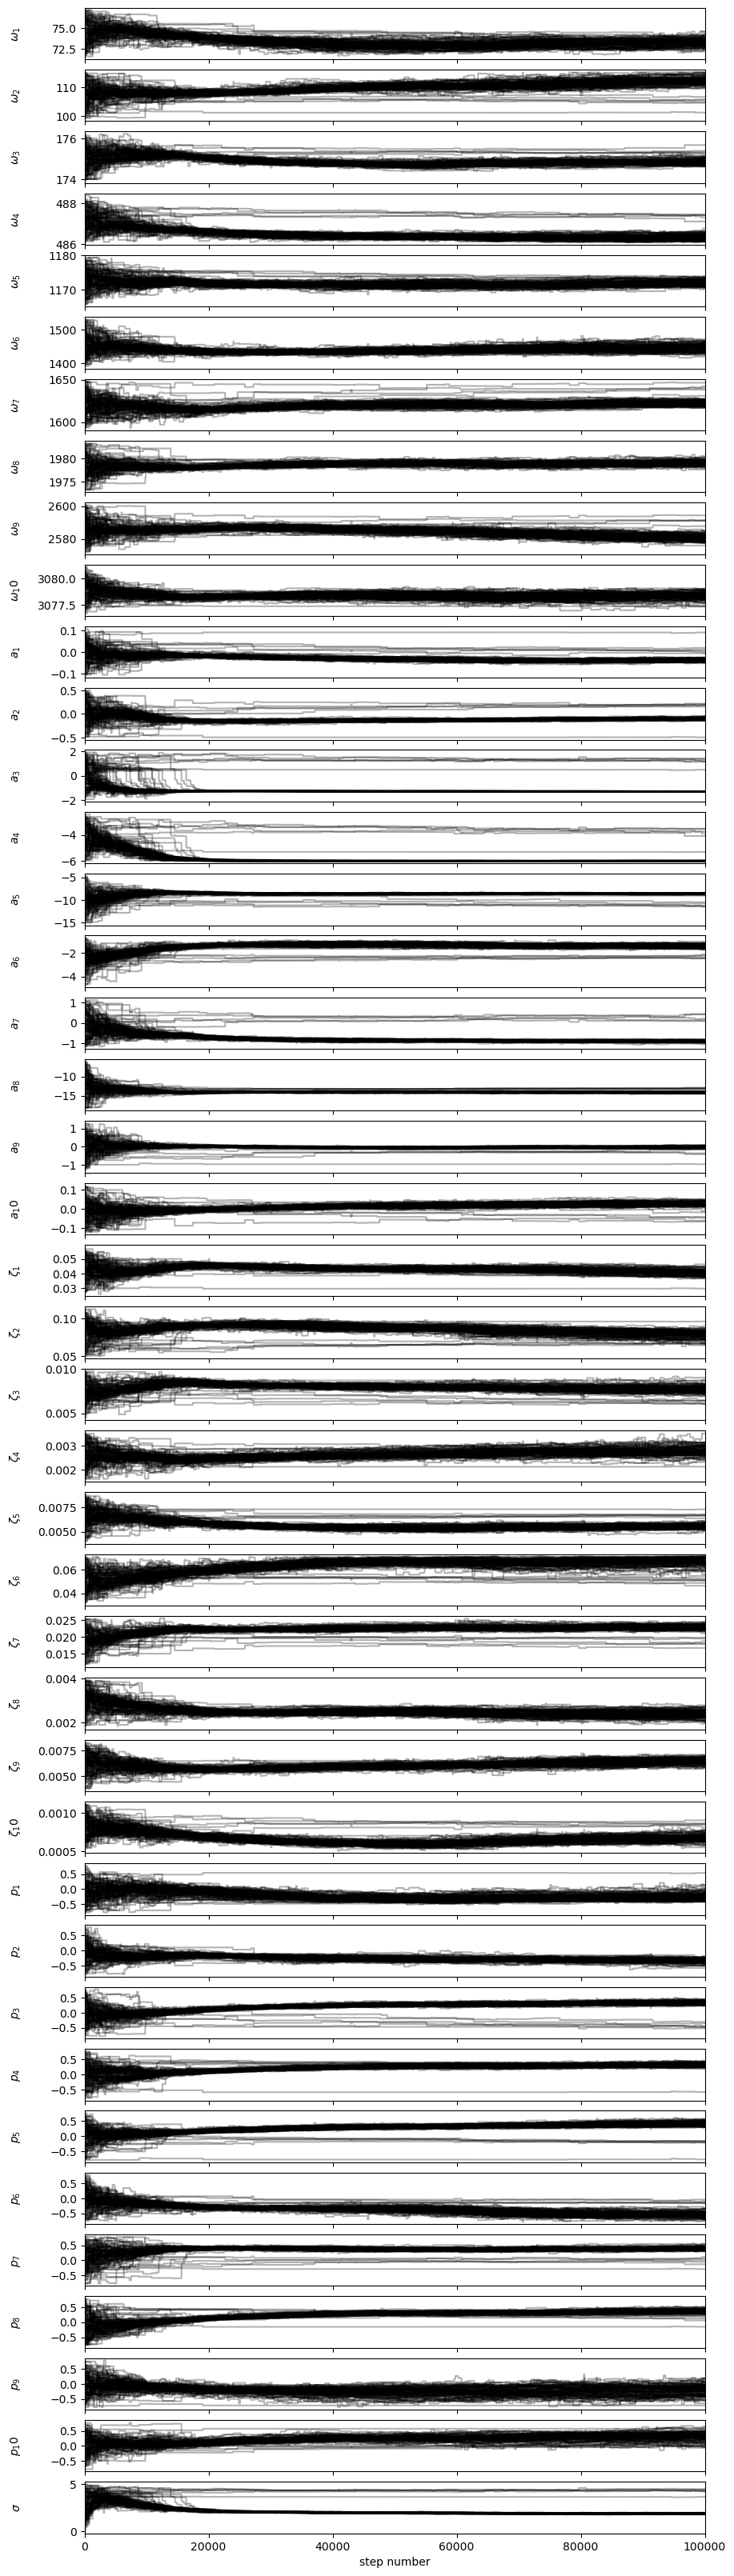

In [121]:
sampler.plot_state_evolution()

In [122]:
sampler.burn_in(45000)

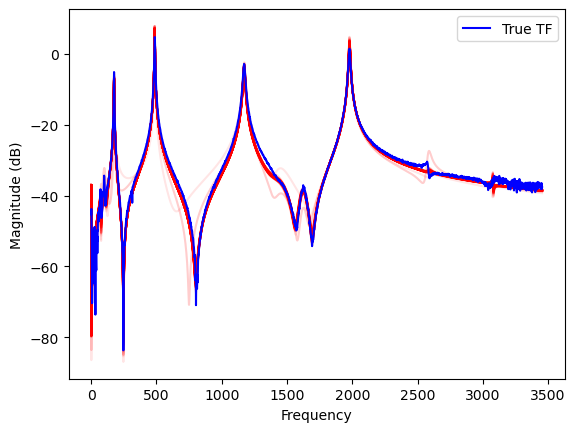

In [143]:
sampler.plot_posterior_samples()

In [16]:
import matplotlib as mpl

In [17]:
mpl.rcParams.update(mpl.rcParamsDefault)

<Figure size 640x480 with 0 Axes>

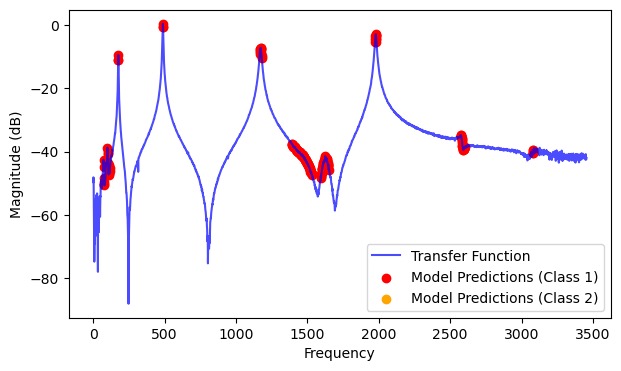

[ 7.14129219e+01  9.90566336e+01  1.73925020e+02  4.86068598e+02
  1.16564318e+03  1.39140016e+03  1.59296889e+03  1.97306992e+03
  2.57201701e+03  3.07651475e+03 -1.10598011e-01 -4.99205301e-01
 -1.93826377e+00 -6.02182885e+00 -1.51537612e+01 -4.71020856e+00
 -1.18478943e+00 -1.85508925e+01 -1.31282375e+00 -1.22799801e-01
  2.58397933e-02  5.01792115e-02  4.38596491e-03  1.57604413e-03
  3.92927308e-03  3.15457413e-02  1.13717129e-02  1.74672489e-03
  3.71112596e-03  4.98815314e-04 -5.00000000e+00]
[ 7.71720285e+01  1.15182132e+02  1.76228662e+02  4.88372240e+02
  1.17946503e+03  1.52961871e+03  1.64825631e+03  1.98343632e+03
  2.60081254e+03  3.08112203e+03  1.10598011e-01  4.99205301e-01
  1.93826377e+00 -2.38567471e+00 -4.57622227e+00 -6.25920361e-01
  1.18478943e+00 -6.13600381e+00  1.31282375e+00  1.22799801e-01
  5.81395349e-02  1.12903226e-01  9.86842105e-03  3.54609929e-03
  8.84086444e-03  7.09779180e-02  2.55863539e-02  3.93013100e-03
  8.35003340e-03  1.12233446e-03 -1.0000

In [181]:
sampler2 = Sampler(model, tf, waxis)
sampler2.run_sampler(nwalkers=100, nsteps=30000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, phase=False)

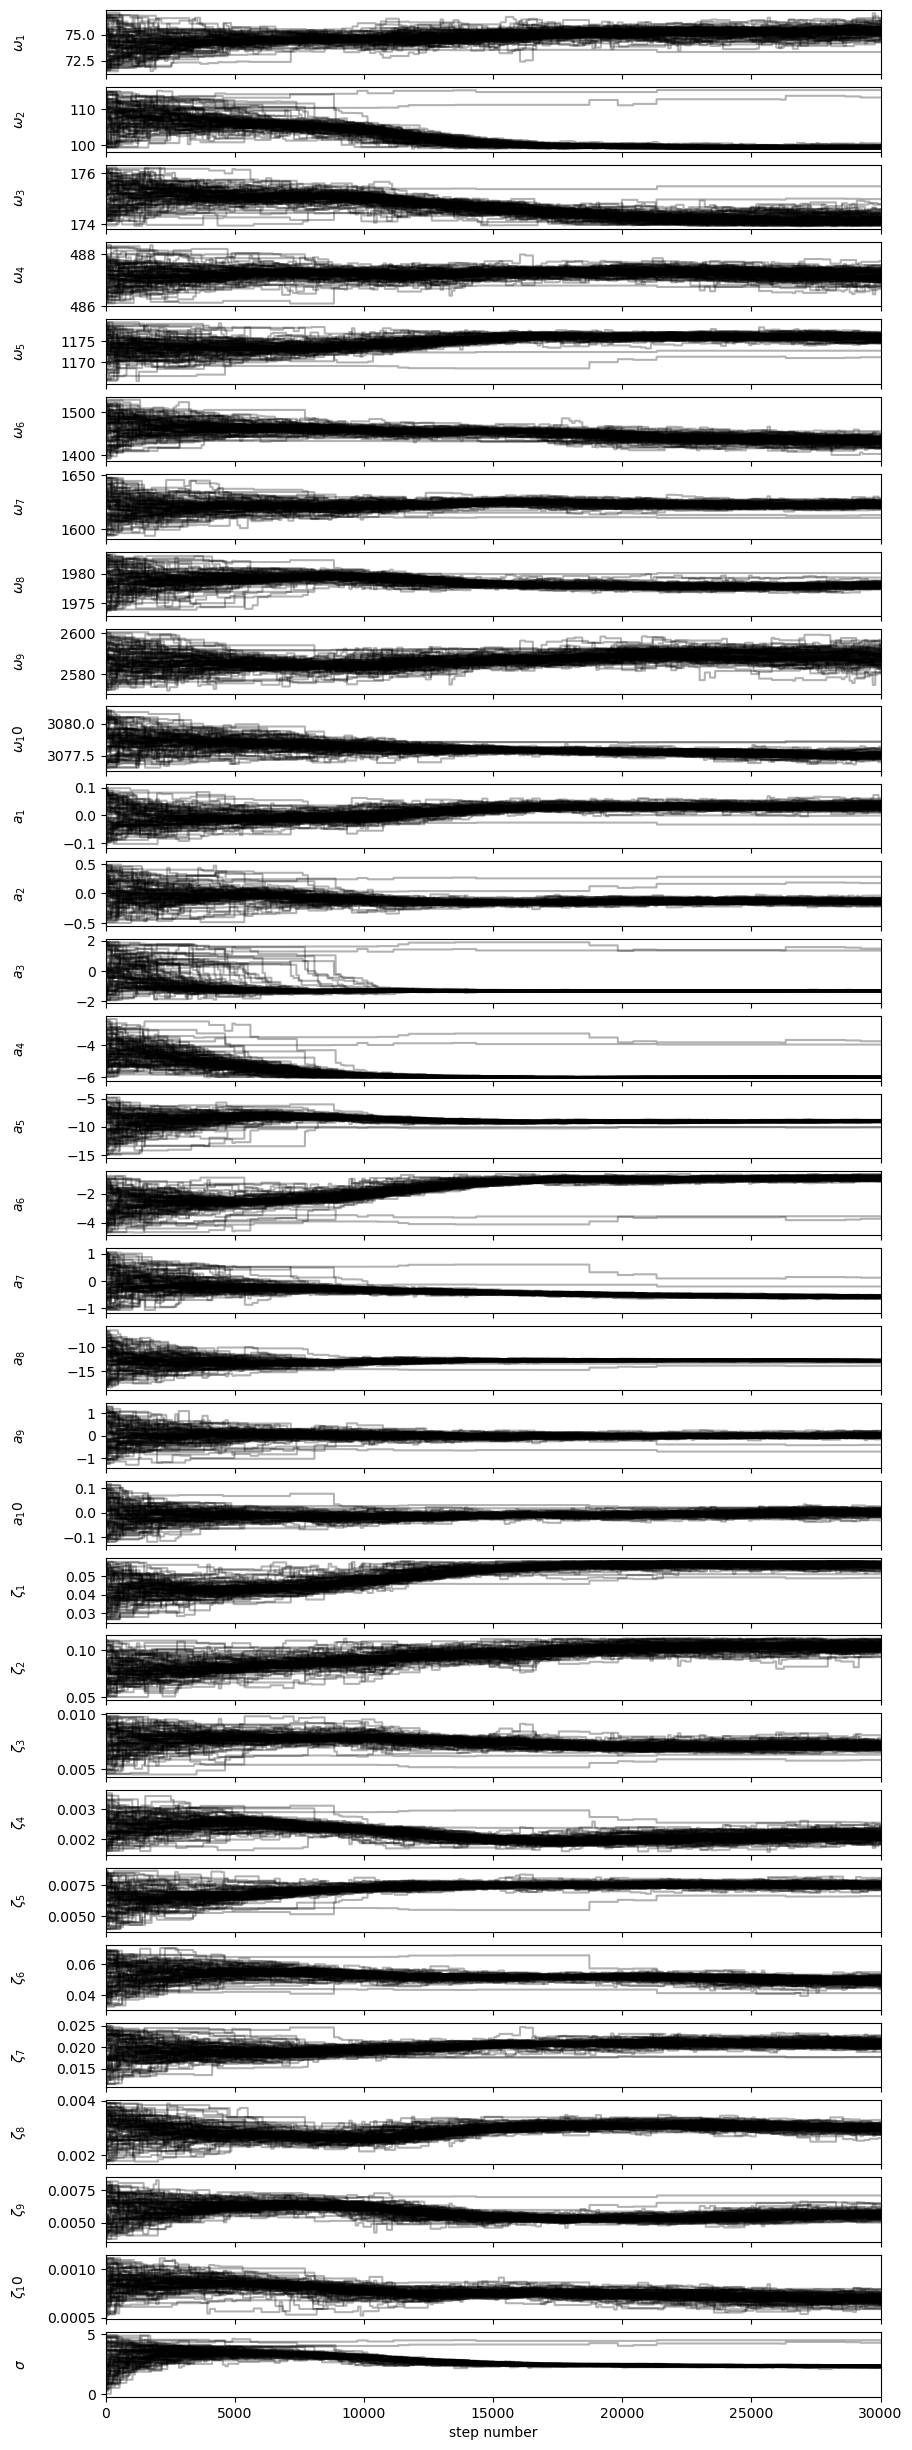

In [182]:
sampler2.plot_state_evolution()

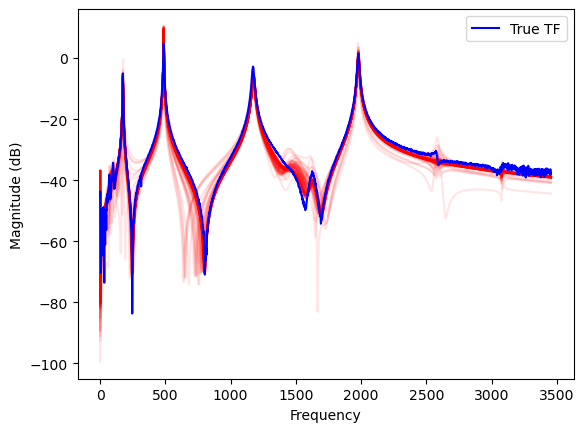

In [185]:
sampler2.plot_posterior_samples()

## 09/05

### Try noisy data

In [201]:
tf_noisy, waxis_noisy = load_sampling_data(cutoff=-1)

2024-05-09 14:14:29.211 python[53294:56551450] +[CATransaction synchronize] called within transaction


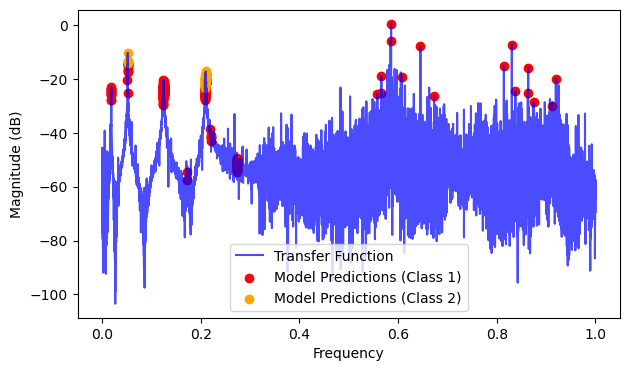

array([[ 4.5908914, -4.1686664, -6.085945 ],
       [ 5.7951617, -5.4862924, -7.8486433],
       [ 6.8205137, -6.443952 , -9.266502 ],
       ...,
       [ 3.6804893, -3.2780921, -7.02607  ],
       [ 3.3575814, -2.9207637, -6.8696327],
       [ 2.9048285, -2.163687 , -5.9118004]], dtype=float32)

In [209]:
lab.lab_predictions(model, tf_noisy, extended=True, multiclass=True, max_norm=True)

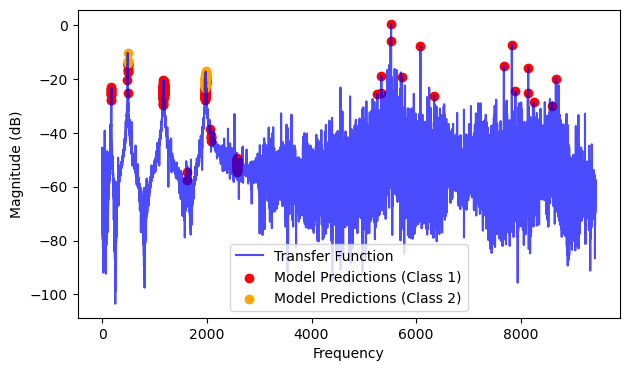

[ 1.65141219e+02  4.59211968e+02  4.61201621e+02  4.70950922e+02
  1.09868652e+03  1.10186996e+03  1.53939471e+03  1.86350922e+03
  1.86649370e+03  1.89116540e+03  1.94926328e+03  1.98089877e+03
  2.44607969e+03  2.45503313e+03 -2.82841379e+00  9.00367817e-02
 -1.58733802e+01  5.30872954e-02 -1.03171500e-01 -2.00000000e+01
 -2.00000000e+01  7.09090076e-01 -2.00000000e+01 -2.00000000e+01
 -2.00000000e+01 -1.10120040e-01 -4.26288048e-01 -2.43021956e-02
  5.18031480e-03  1.00000000e-04  2.43570456e-03  1.00000000e-04
  1.00000000e-04  5.72860723e-03  1.00000000e-04  4.62345514e-04
  3.39378513e-03  1.00000000e-04  1.00000000e-04  1.33895695e-04
  1.10980281e-03  1.00000000e-04 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -5.00000000e+00]
[ 1.85383323e+02  5.07550070e+02  5.13487614e+02  5.20524703e+02
  1.214

In [245]:
sampler2 = Sampler(model, tf_noisy, waxis_noisy)
sampler2.run_sampler(nwalkers=100, nsteps=10000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, phase=True, sample_cutoff=14000)

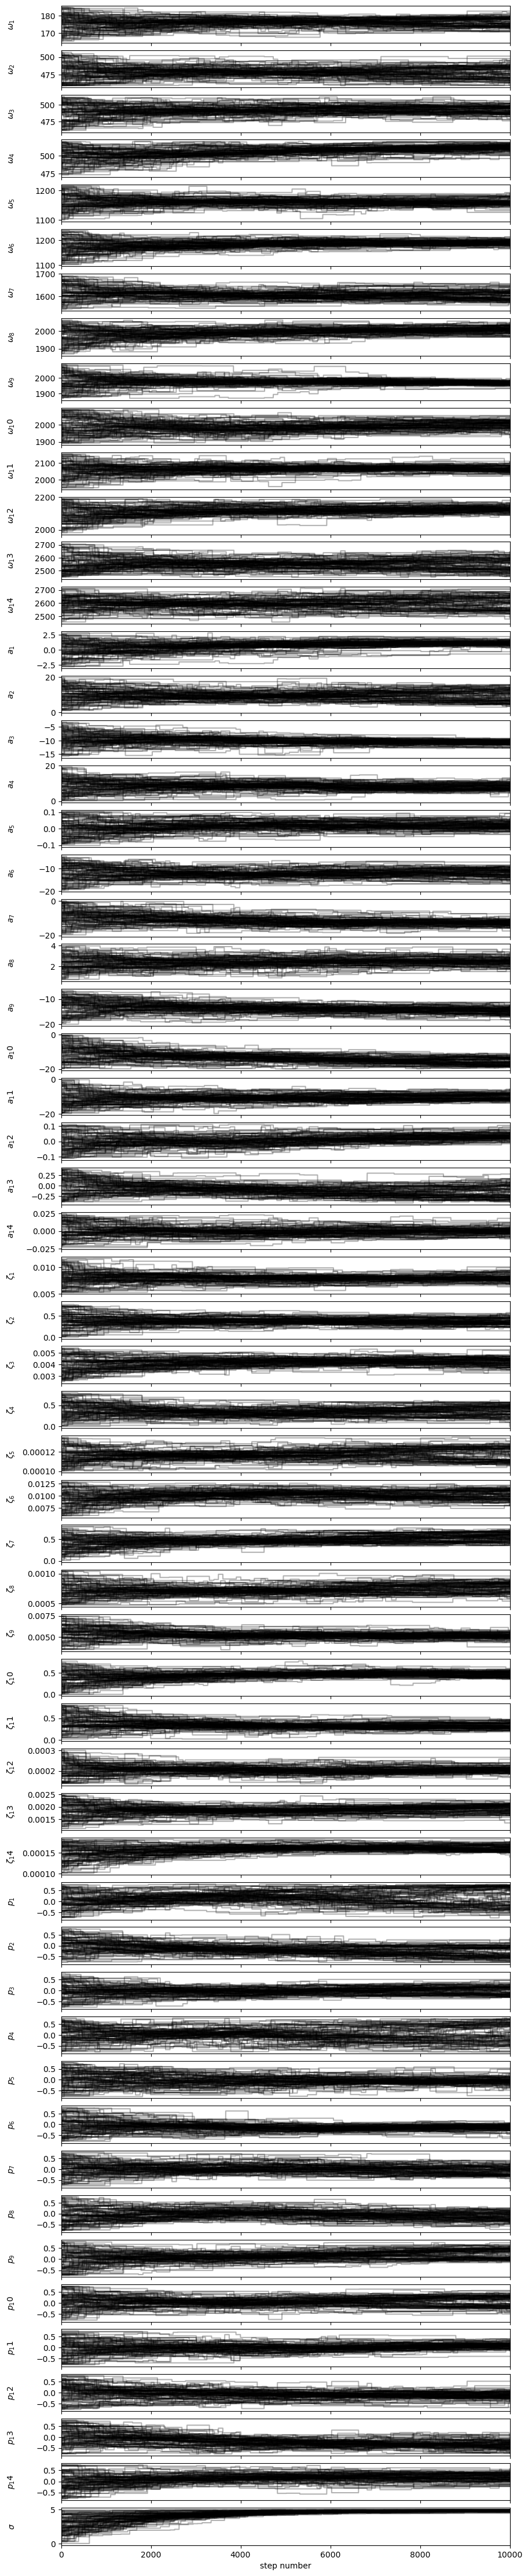

In [246]:
sampler2.plot_state_evolution()

In [247]:
sampler2.burn_in(5000)

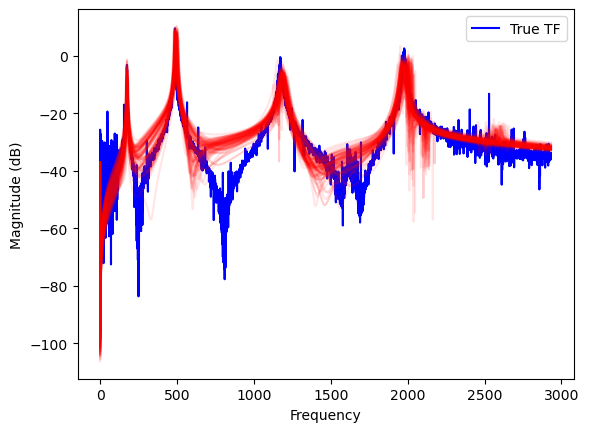

In [248]:
sampler2.plot_posterior_samples()

### 4C6 Data

In [8]:
tf_dict, waxis_4c6 = load_sampling_data(cutoff = -1, tf_type="acc", num_tfs=12)

2024-05-14 09:30:23.361 python[90636:60296665] +[CATransaction synchronize] called within transaction


In [9]:
print(waxis_4c6)

[6.98054139e-01 2.09416242e+00 4.18832484e+00 ... 9.41744839e+03
 9.41954255e+03 9.42163672e+03]


#### Channel 4 (Good performance)

/Users/vaibhav/Documents/Engineering/Project/src/lab.py:72: RuntimeWarning: divide by zero encountered in divide
  phase = np.arctan(np.imag(tf_arr)/np.real(tf_arr))


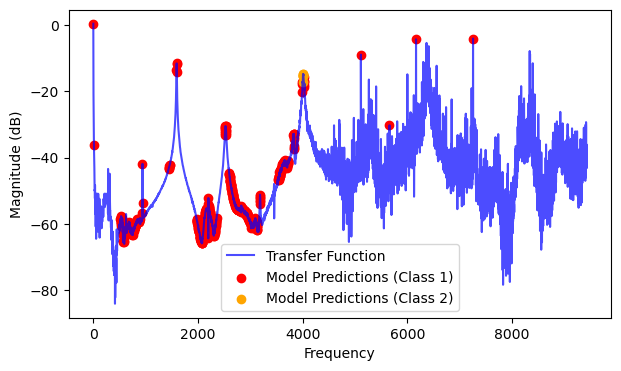

[ 9.94727148e+00  4.93384666e+02  6.06783561e+02  8.91275525e+02
  1.36874456e+03  1.38267074e+03  1.50999581e+03  1.87605540e+03
  2.38734516e+03  2.46493387e+03  3.02198108e+03  3.35819885e+03
  3.63274355e+03  3.79189989e+03  8.95055488e+03 -2.10232715e-02
 -3.26337182e-02 -1.14974900e-01 -1.14940228e-02 -1.00313361e-02
 -1.10562772e-02 -5.67680731e-01 -3.46541430e-01 -2.79565880e-01
 -1.18538323e+00 -1.17824095e-02 -5.94931866e-01 -1.46539513e-01
 -2.09185776e+00  3.01516245e-03  6.06060606e-02  4.15879017e-02
  1.07290234e-01  1.48478099e-03  9.67585873e-04  9.57854406e-04
  1.31492439e-03  5.86718246e-02  3.59165631e-03  6.26447288e-02
  1.31406045e-03  1.71236171e-02  1.63889648e-03  2.78648555e-03
  1.00000000e-04 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -5.00000000e+00]
[ 1.319

In [323]:
channel_4 = Sampler(model, tf_dict["tf_4"], waxis_4c6)
channel_4.run_sampler(nwalkers=100, nsteps=30000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, phase=True, sample_cutoff=2500)

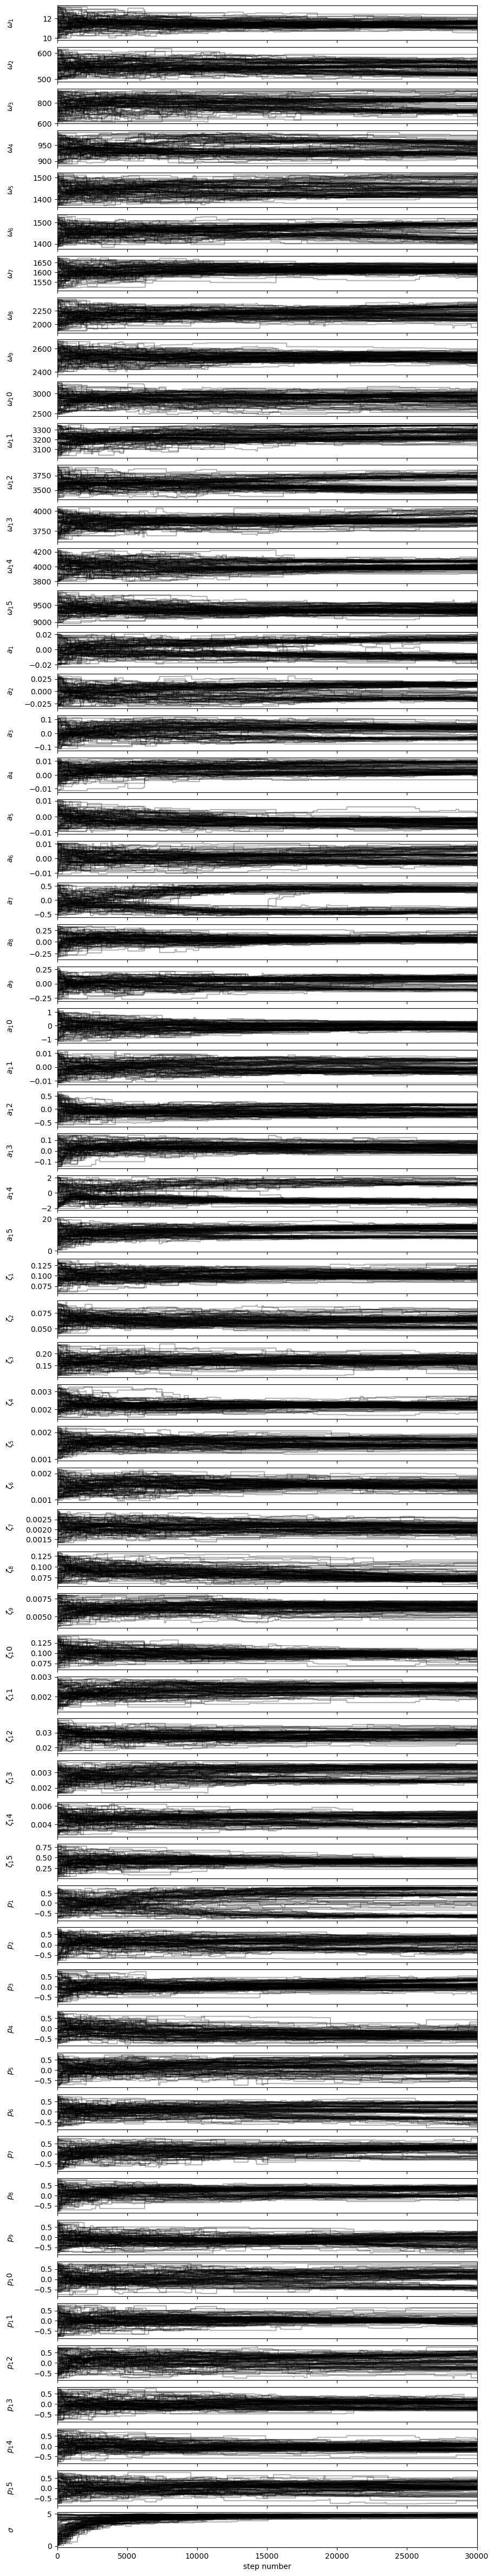

In [324]:
channel_4.plot_state_evolution()

In [325]:
channel_4.burn_in(15000)

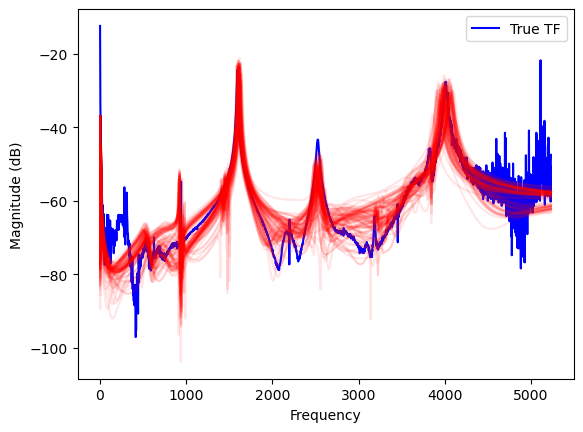

In [332]:
channel_4.plot_posterior_samples()

#### Channel 5

/Users/vaibhav/Documents/Engineering/Project/src/lab.py:72: RuntimeWarning: divide by zero encountered in divide
  phase = np.arctan(np.imag(tf_arr)/np.real(tf_arr))


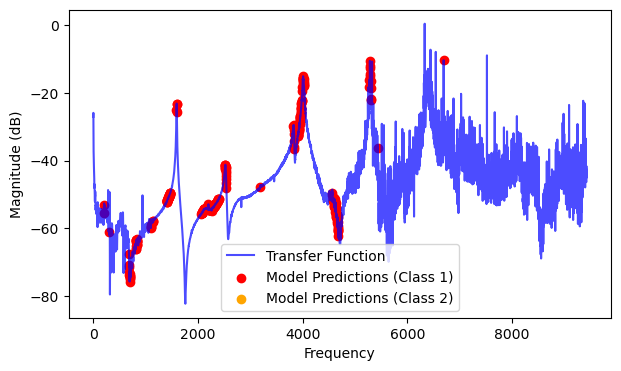

[ 2.00934884e+02  6.46572646e+02  7.69918813e+02  7.91802810e+02
  1.04247405e+03  1.08624205e+03  1.32895547e+03  1.50999581e+03
  1.96359139e+03  2.38734516e+03  3.63075409e+03  3.71033226e+03
  3.79388934e+03  4.33899982e+03  4.36685218e+03 -2.64133374e-03
 -6.48223329e-03 -7.31763680e-03 -4.20526629e-03 -4.05243317e-03
 -3.10011983e-03 -1.43241059e-01 -2.49468287e-01 -5.38967034e-01
 -1.45607877e-01 -4.00873351e-01  4.44736052e-01  8.44574108e-01
 -2.81284000e-02 -1.35916356e-01  3.28407225e-03  1.20845921e-02
  7.66283525e-03  4.16146484e-03  1.90294957e-03  1.21876904e-03
  1.70192074e-02  1.31492439e-03  4.91162209e-02  3.86633527e-03
  1.82149362e-03  6.54809309e-03  2.61164795e-03  1.06813153e-03
  6.16866020e-03 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -5.00000000e+00]
[ 2.242

In [333]:
channel_5 = Sampler(model, tf_dict["tf_5"], waxis_4c6)
channel_5.run_sampler(nwalkers=100, nsteps=30000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, phase=True, sample_cutoff=2500)

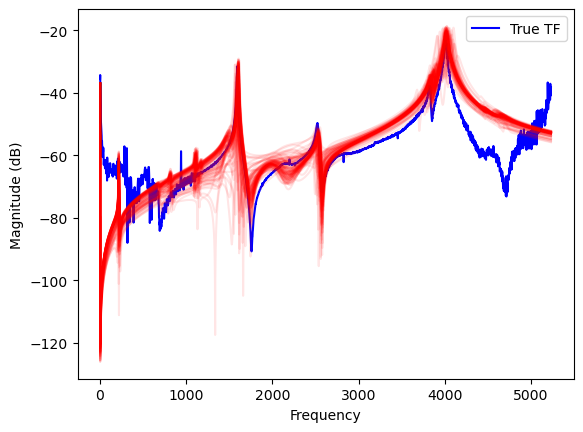

In [334]:
channel_5.plot_posterior_samples()

#### Channel 6

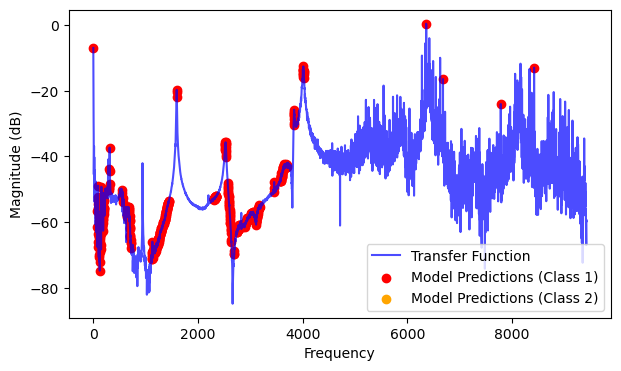

[ 7.16203547e+01  2.86481419e+02  5.23226480e+02  5.39142114e+02
  6.10762469e+02  1.06236859e+03  1.26330348e+03  1.51198527e+03
  2.18243136e+03  2.19237864e+03  2.38734516e+03  2.43907097e+03
  2.55644877e+03  2.60817458e+03  2.71162621e+03  2.73152075e+03
  2.85486692e+03  2.87078255e+03  3.28061014e+03  3.38804067e+03
  3.63473300e+03  3.79786825e+03 -1.58104546e-01 -3.82326751e-02
 -2.87812979e-03 -1.06516669e-03 -2.94922879e-02 -3.91102307e-02
 -5.39179747e-02 -9.47940895e-02 -3.10118550e-03 -2.29274825e-02
 -1.06113672e-01 -5.80794105e-02 -3.32360395e-04 -1.01886599e-02
 -3.46895853e-03 -1.80660925e-02 -6.12271704e-04 -6.34282809e-02
 -3.74495559e-03 -2.19619273e-01 -1.89050568e-01 -1.29801031e+00
  3.16301703e-01  1.36054422e-02  2.52525253e-03  1.22774708e-03
  3.69230769e-02  5.34022394e-02  2.71903323e-02  8.76040298e-04
  9.10332271e-04  5.99520384e-03  3.86633527e-03  8.58829844e-03
  5.18403318e-04  6.04686319e-03  1.95074372e-03  8.15347722e-03
  2.32207129e-04  1.66666

In [335]:
channel_6 = Sampler(model, tf_dict["tf_6"], waxis_4c6)
channel_6.run_sampler(nwalkers=100, nsteps=30000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, phase=True, sample_cutoff=2500)

In [336]:
channel_6.burn_in(15000)

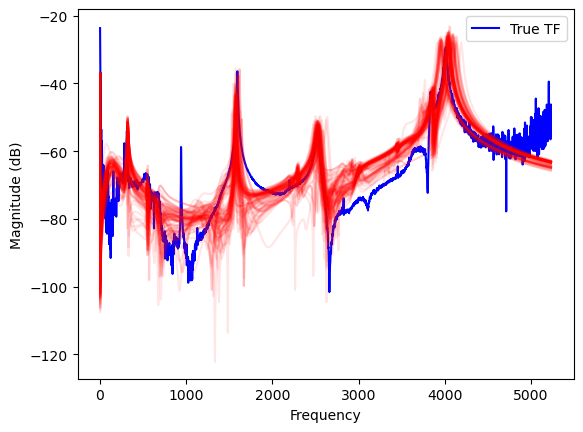

In [337]:
channel_6.plot_posterior_samples()

### Sampling using synthetic TFs

In [106]:
def generate_dat_extended(num_data, num_w_points, sigma_max = 0.15, max_modes = 7,
                multiclass = False, normalise = None, neg_an=False, logmag=False, scaled_logmag=False, a_max=2.0, verbose_op=False):
    """Generate num_data training examples with num_w_points frequency points.
    Pass normalisation function as a parameter. Include phase and magnintude 
    information in the output.
    X: (num_data, num_w_points, 4)
    Y: (num_data, num_w_points)
    ws: (num_data, max_modes)
    zs: (num_data, max_modes)"""
    X = []
    Y = []
    ws = []
    zs = []
    a_s = []
    phases = []
    w = np.linspace(0, 1, num_w_points)
    for i in range(num_data):
        num_modes = np.random.randint(0, max_modes + 1)
        w_n = np.random.uniform(0, 1, num_modes)
        if neg_an:
            mag = np.random.uniform(-a_max, a_max, num_modes)
            phase = np.random.normal(0, np.pi / 9, num_modes) ## CHANGED 
            a_n = mag * np.exp(1j * phase)  # combine mag and phase to make a complex num
            a_s.append(a_n)
            phases.append(phase)
        else:
            a_n = np.random.uniform(1, 2, num_modes)
        # z_n = np.random.uniform(0.01, 0.20, num_modes)
        z_n = 10 ** (np.random.uniform(-3, -0.7, num_modes)) # log-uniform sampling of z_n
        sigma = np.random.uniform(0.001, sigma_max)
        out, y = modal.modal_sum(w, a_n, z_n, w_n, sigma, multiclass)

        if normalise is not None:
            out = normalise(out)

        real_imag = modal.split_real_imag(out)
        phase = np.arctan(np.imag(out)/np.real(out))
        # phase = np.mod(phase, 2*np.pi)
        mag = np.abs(out)
        # max_mag = np.max(mag)
        # mag = mag / (0.95 * max_mag)
        # real_imag = real_imag / (0.95 * max_mag)

        if logmag is True:
            logmagnitude = np.log10(mag)
            if scaled_logmag is True:
                logmagnitude = (logmagnitude - np.mean(logmagnitude)) / np.std(logmagnitude)
            extended_op = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1), logmagnitude.reshape(-1,1)), axis=1)
        else:
            extended_op = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1)), axis=1)
        ws.append(w_n)
        zs.append(z_n)
        X.append(extended_op)
        Y.append(y)
    if verbose_op:
        return np.array(X), np.array(Y), ws, zs, a_s, phases
    return np.array(X), np.array(Y), ws, zs

In [143]:
valX, valy, ws, zs, a_s, phases = generate_dat_extended(32*1, 1000, multiclass=True, neg_an=True, verbose_op=True, max_modes=4, sigma_max=0.1) 

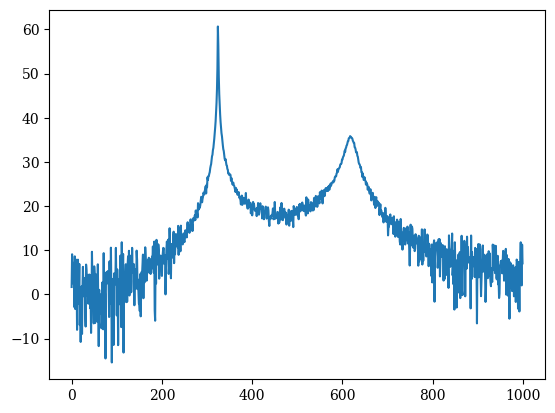

In [146]:
index = 11
plt.plot(modal.to_db(valX[index,:,:2]))
plt.show()

In [147]:
print(f'w: {ws[index]}, z: {zs[index]}, a: {np.abs(a_s[index])}, p:{phases[index]}')

w: [0.32463394 0.61923806 0.84474733], z: [0.0010557  0.01854457 0.06907725], a: [0.9992247  1.38653132 0.03727594], p:[0.03578544 0.2065492  0.07832918]


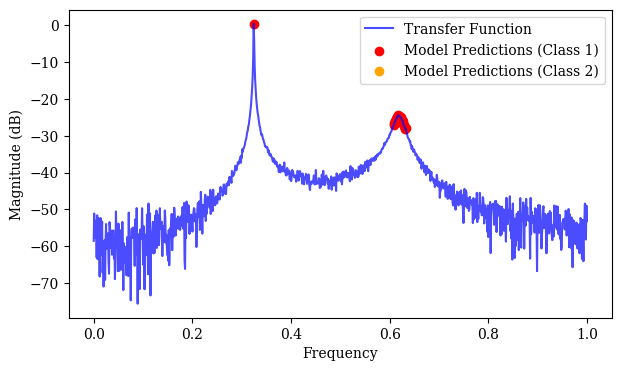

[ 3.08108108e-01  5.78178178e-01 -2.00000000e+01 -2.27643649e+00
  1.00000000e-04  1.29032258e-02 -5.00000000e+00]
[ 0.34054054  0.66426426 -0.07007629  2.27643649  0.8         0.02903226
 -1.        ]
Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Current   Time m:s
0     9     -11985.75 -11985.75   0:00.0
1     18    -11715.63 -11715.63   0:00.0
2     27    -11513.56 -11513.56   0:00.0
3     36    -11113.39 -11113.39   0:00.0
20    189   -5269.999 -5269.999   0:00.0
40    369   -3565.715 -3569.653   0:00.0
60    549   -3480.308 -3488.348   0:00.0
80    729   -3374.931 -3385.504   0:00.1
100   909   -3362.817 -3363.718   0:00.1
120   1089  -3360.752 -3360.752   0:00.1
140   1269  -3359.968 -3360.026   0:00.1
160   1449  -3359.935 -3359.935   0:00.1
180   1629  -3359.869 -3359.869   0:00.1
200   1809  -3359.751 -3359.751   0:00.1
220   1989  -3359.721 -3359.722   0:00.2
240   2169  -3

In [148]:
tf = valX[index,:, 0] + 1j * valX[index,:,1]
synth_sampler = Sampler(model, tf)
synth_sampler.run_sampler(nwalkers=100, nsteps=30000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, phase=False, return_results=True)

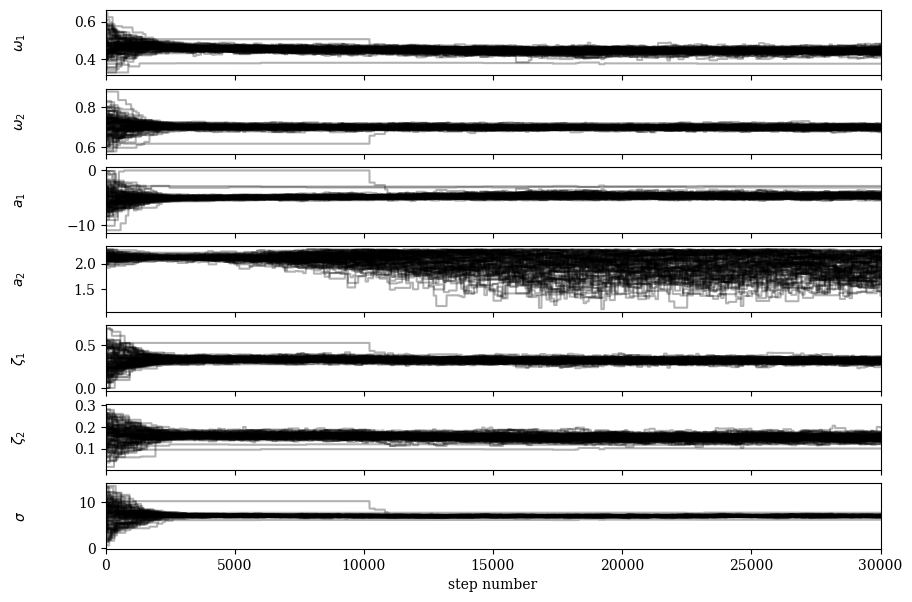

In [149]:
synth_sampler.plot_state_evolution()

In [130]:
synth_sampler.burn_in(5000)

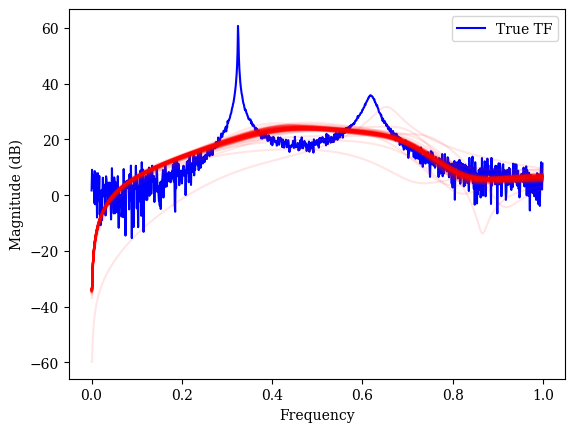

In [150]:
synth_sampler.plot_posterior_samples()

In [151]:
truths = np.concatenate((ws[index], np.abs(a_s[index]), zs[index], phases[index], [None]))
print(truths.shape)

(13,)


ValueError: Provided figure has 169 axes, but data has dimensions K=17

<Figure size 640x480 with 0 Axes>

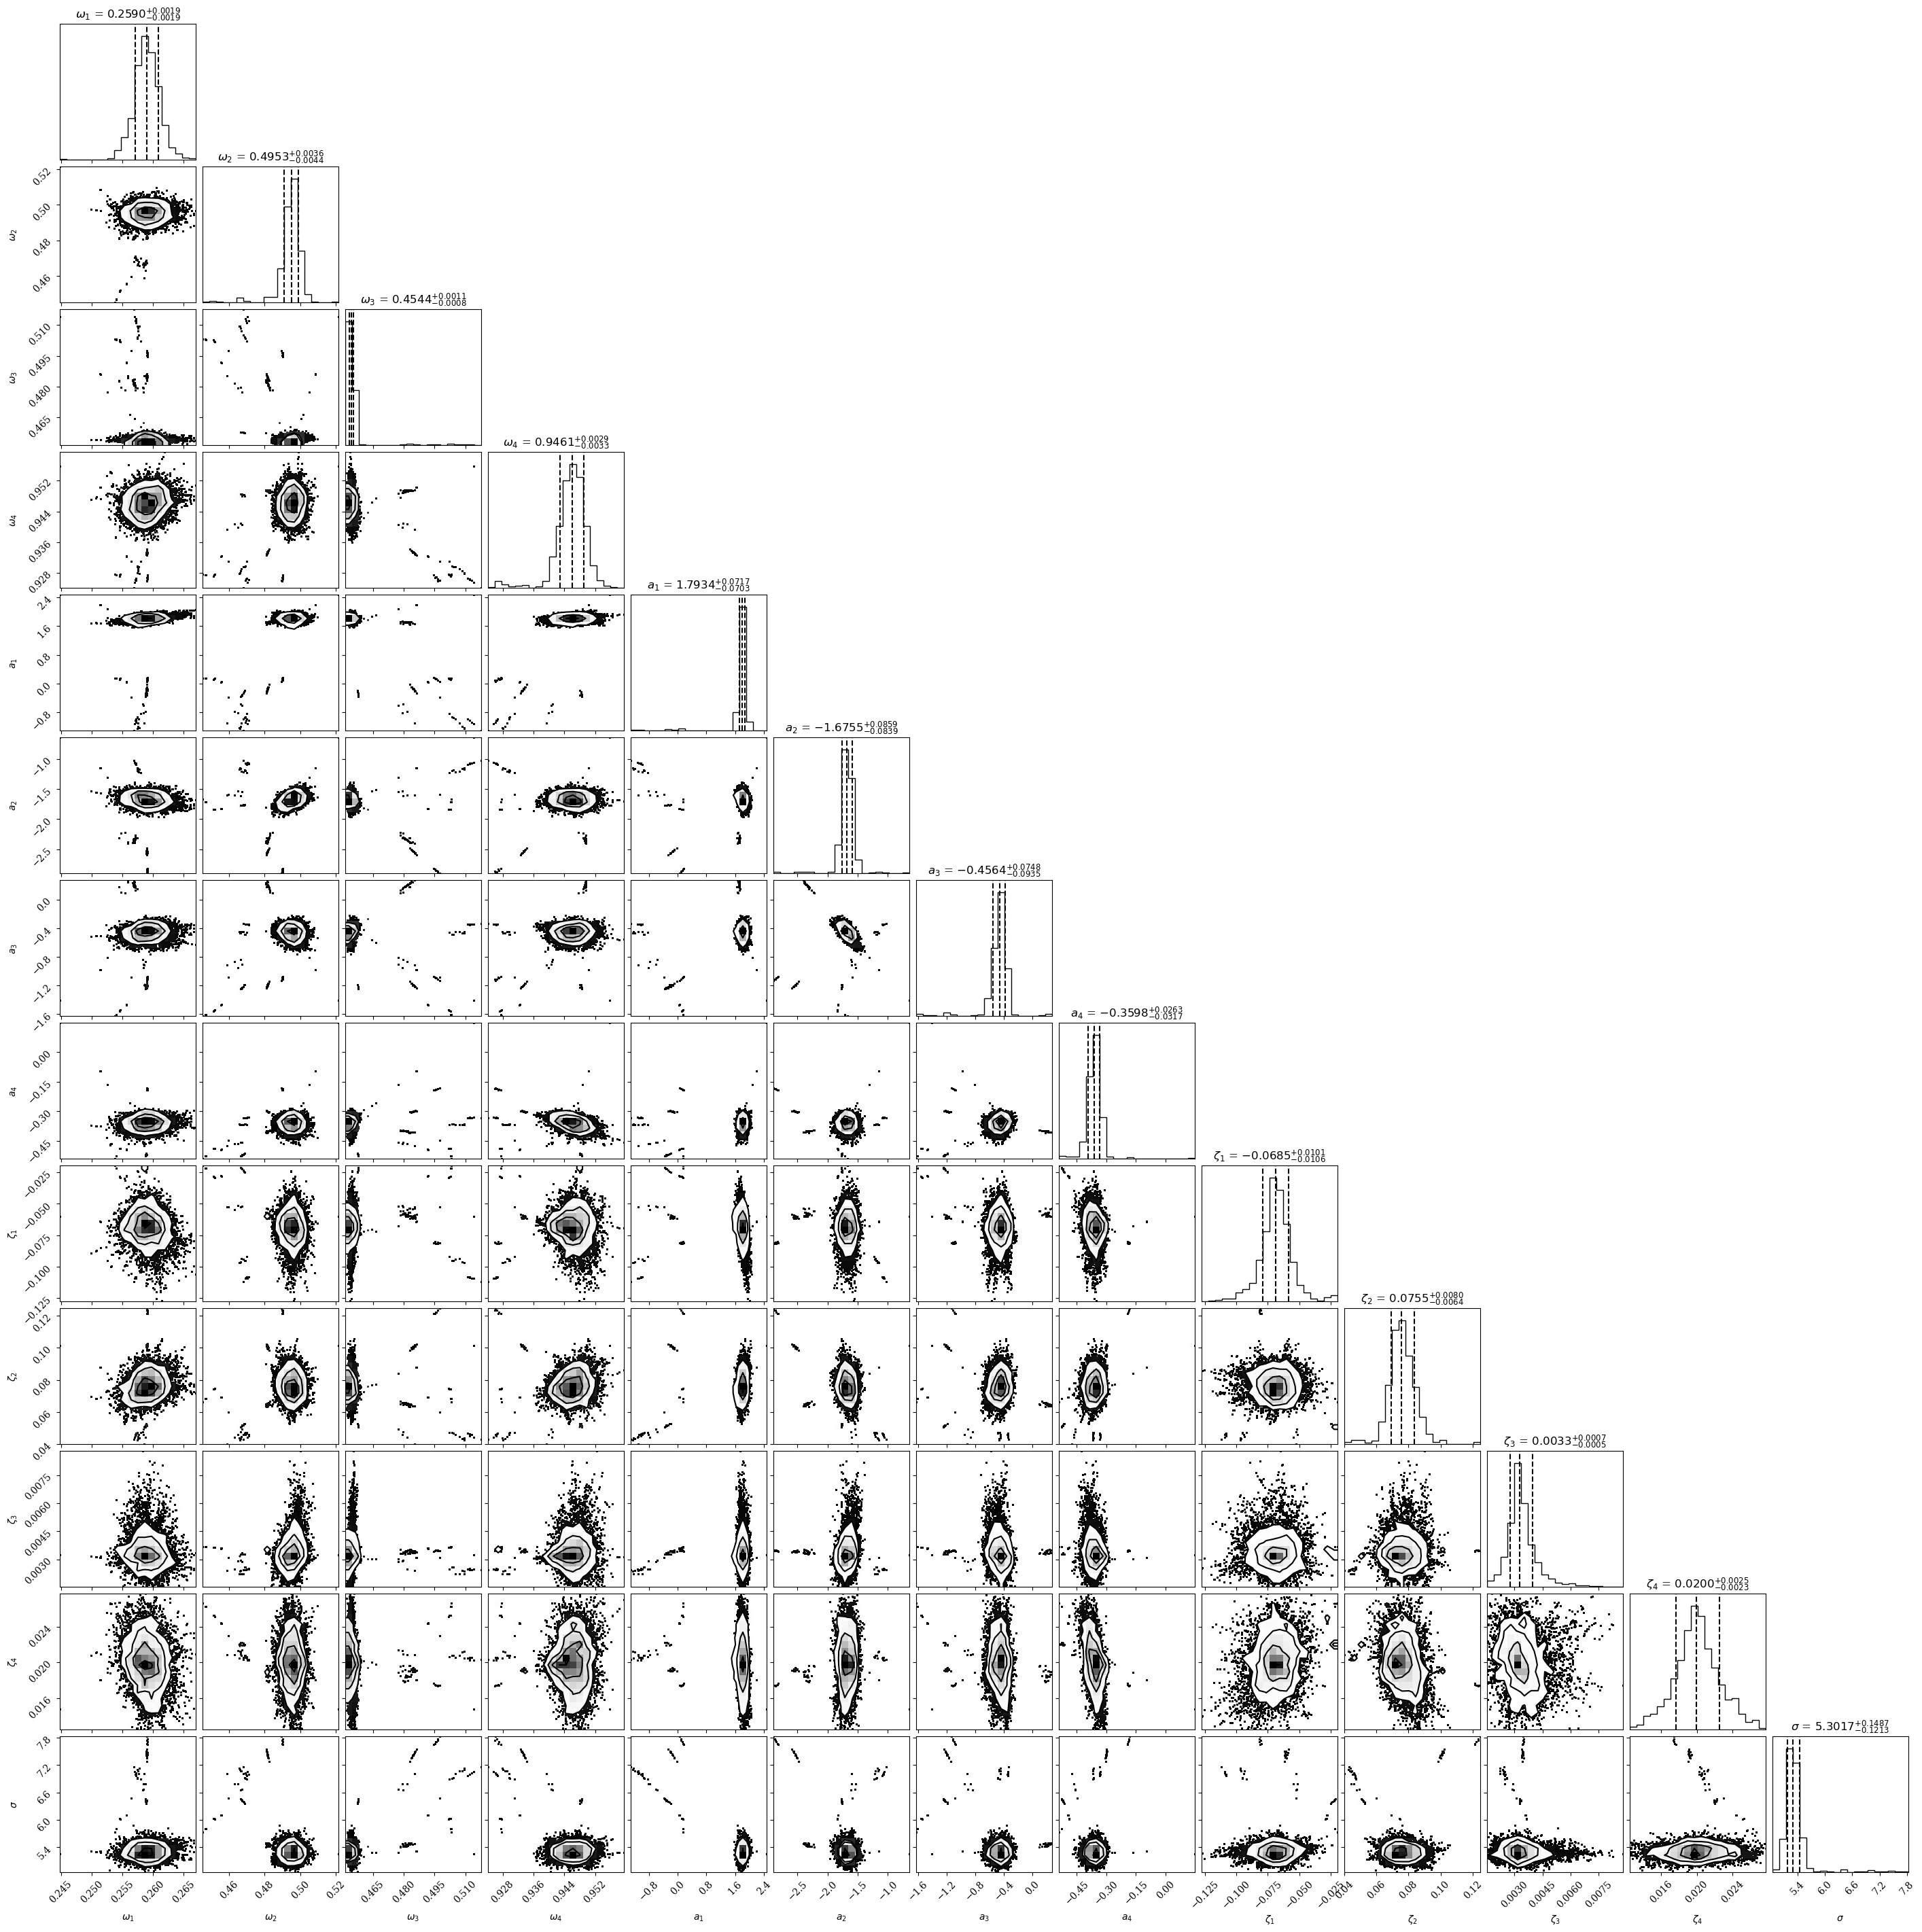

In [135]:
synth_sampler.plot_corner(truths=truths)